In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from scipy.interpolate import spline

plt.style.use('bmh')
%matplotlib inline

## Dataset

The clinical trial dataset contains 264,949 records (5,197 MB) of research studies in all 50 states in US and in 203 countries.

The dataset is designed to help:
* Patients and Families: 
    * To search for actively recruiting studies to participate in; 
    * To learn about new interventions/treatments that are being considered.
* Researchers and related institutions:
    * To search the database to stay up to date on developments in relevant fields;
    * To find collaborators, and to identify unmet needs.
* Study Record Managers:
    * To Learn about registering studies and about submitting their results after study completion.

In [2]:
dir_trial = '/Users/wanwanbeen/Desktop/AllPublicXML/'
xml_all = sorted(glob(dir_trial+'*/*.xml'))
print 'Number of clinical trials =', len(xml_all)

def get_size(dir_trial):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(dir_trial):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

print 'File size = ', get_size(dir_trial)/(1024**2), 'MB'

Number of clinical trials = 264949
File size =  5197 MB


## Load relevant information: 
* Condition: targeted disease of each trial
* StartDate: start date of each trial
* InterType: proposed intervention type (drug, procedure, etc.) of each trail
* InterName: proposed intervention name (e.g. name of drugs) of each trail

In [ ]:
def read_xml(xml_all):
    np.random.seed(3131)
    N_test    = np.random.permutation(len(xml_all))
    NN_test   = len(xml_all)/3
    TrialID   = [0]*NN_test
    Condition = ['']*NN_test 
    StartDate = ['']*NN_test
    InterType = ['']*NN_test
    InterName = ['']*NN_test

    for id in range(NN_test):    
        xml_path = xml_all[N_test[id]]
        tree = ET.parse(xml_path)
        root = tree.getroot()    
        TrialID[id] = id
        if root.find('condition') is not None:
            Condition[id] = root.findall('condition')[0].text
        if root.find('start_date') is not None:
            StartDate[id] = int(root.find('start_date').text.split()[-1])
        if root.find('intervention') is not None:
            InterType[id] = root.findall('intervention')[0].find('intervention_type').text
            InterName[id] = root.findall('intervention')[0].find('intervention_name').text
    df = pd.DataFrame({'TrialID':TrialID,'Condition':Condition,
                       'StartDate':StartDate,'InterType':InterType,'InterName':InterName})
    return df

df = read_xml(xml_all)

## Brief summary of the data

In [17]:
def plot_by_year(Input, Field, Num):
    
    TopList = Input[Field].value_counts().index.tolist()
    NNow = NTop = 0
    grouped = Input.groupby(Field).groups
    plt.figure()
    plot_mark = ['r>-','bs-','yv-','co-','md-','g<-','r--','b--','y--','m--']
    ymax = 0
    while NNow < Num and NTop < len(TopList):    
        name = TopList[NTop]
        if name != 'Healthy':
            Date = Input['StartDate'][grouped[name]].value_counts()
            Year = np.array(Date.index.tolist())
            Count = np.array(Date.values)
            Ord = np.argsort(Year)
            Year = np.int16(Year[Ord][1:])
            Count = np.int16(Count[Ord][1:])
            plt.plot(Year, Count,plot_mark[NNow],label=name)
            ymax = max(ymax,np.max(Count))
            NNow += 1
        NTop += 1
    plt.xlim([1990,2017])
    plt.ylim([0,ymax+2])
    plt.xlabel('Year')
    plt.ylabel('Number of Trials')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Inspect the major diseases

* We can inspect the attention to major diseases, by piloting here the number of trails per year (in [1990, 2017]) for the top 5 most frequent diseases.
* For example, in this plot, we can tell that breast cancer and obesity are the leading diseases for study after 2008, while HIV attracts research attention mostly before 2008.

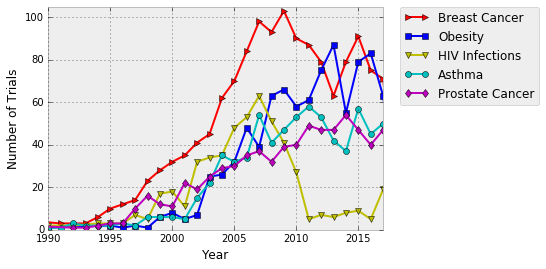

In [14]:
plot_by_year(df, 'Condition',5)

### Inspect the treatments/interventions of each disease

* We can also inspect the treatments/interventions used for each disease, versus time.
* This provides information on the recent research progress for this type of disease.
* Here, treatments/interventions versus time for breast cancer is plotted.
* In this plot, we can tell that drug use is the leading treatment for breast cancer.

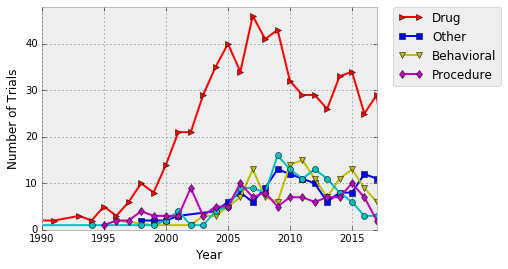

In [15]:
grouped = df.groupby('Condition').groups
plot_by_year(df.loc[grouped['Breast Cancer']], 'InterType',5)

### Inspect the details of treatments/interventions of each disease

* More specifically, we can inspect the details of the interventions.
* For example, here we plot different types of drugs used to study breast cancer treatment.
* This can provide reference for patients, researchers or pharmaceutical companies.

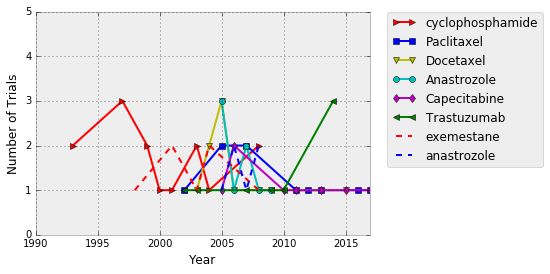

In [19]:
grouped = df.groupby('Condition').groups
dr_new = df.loc[grouped['Breast Cancer']]
grouped = dr_new.groupby('InterType').groups
plot_by_year(dr_new.loc[grouped['Drug']], 'InterName',8)